In [ ]:

api=KaggleApi()
api.authenticate()
os.mkdir("data")
l=["train.csv","test.csv","oil.csv","hol.csv","stores.csv","transactions.csv"]
for i in l:
    api.competition_download_fifle("store-sales-time-series-forecasting",i,force=True)

# CLASSES

In [1]:
import dtale, os, atom, shap
#from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi
import kaggle
from sklearn.pipeline import Pipeline
from functools import wraps
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
pd.options.display.max_columns = 500 # this will set limit of columns to 500
%matplotlib inline
os.getcwd()

'p:\\Python\\GitHub\\forecast_sales'

In [2]:
class filtrator(BaseEstimator, TransformerMixin):
    def __init__(self,mapper_in=None,mapper_out=None):
        self.mapper_in=mapper_in
        self.mapper_out=mapper_out
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        X2=X.copy()
        if self.mapper_in !=None:
            for k,v in self.mapper_in.items():
                X2=X2[X2[k].isin(v)]
        else: pass
        if self.mapper_out !=None:
            for k,v in self.mapper_out.items():
                X2=X2[~X2[k].isin(v)]
        pass
        return X2

In [3]:
class cols_selector(BaseEstimator, TransformerMixin):
    def __init__(self,sel=None,drop=None):
        self.sel=sel
        self.drop=drop
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        if self.sel !=None:
            X2=X.copy()
            X2=X2[self.sel]
        else:
            X2=X.copy()
            X2=X2.drop(self.drop,axis=1)
        return X2

In [4]:
class dtypes(BaseEstimator, TransformerMixin):
    def __init__(self,dict_cols=None):
        self.dict_cols=dict_cols
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        X2=X.copy()
        for k,v in self.dict_cols.items():
            X2[k]=X2[k].astype(v)
        return X2

# IMPORT & EXPLORATION

In [5]:
train=pd.read_csv(r"data/train.csv.zip",index_col='id',parse_dates=['date'])
oil=pd.read_csv(r"data/oil.csv",parse_dates=['date'])
hol=pd.read_csv(r"data/holidays_events.csv",parse_dates=['date'])
stores=pd.read_csv("data/stores.csv")
test=pd.read_csv("data/test.csv",index_col='id',parse_dates=['date'])

# EXPLORATION

In [6]:
from sklearn.model_selection import TimeSeriesSplit

In [7]:
test.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


In [8]:
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


## Merge store metadata

In [9]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## Dataprep OIL

        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
        dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000


<AxesSubplot:xlabel='date'>

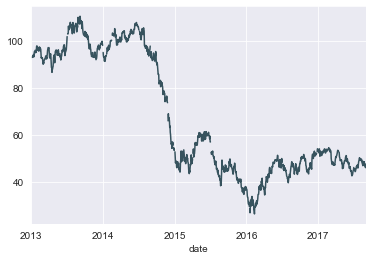

In [21]:
print(oil.head())
print(oil.describe())
oil.set_index('date')['dcoilwtico'].plot()

In [20]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [11]:
hol.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [22]:
print(hol.describe())
hol.isnull().sum()

                       date     type    locale locale_name description  \
count                   350      350       350         350         350   
unique                  312        6         3          24         103   
top     2014-06-25 00:00:00  Holiday  National     Ecuador    Carnaval   
freq                      4      221       174         174          10   
first   2012-03-02 00:00:00      NaN       NaN         NaN         NaN   
last    2017-12-26 00:00:00      NaN       NaN         NaN         NaN   

       transferred  
count          350  
unique           2  
top          False  
freq           338  
first          NaN  
last           NaN  


date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [12]:
mask = hol.description=='Viernes Santo'
hol2=hol.copy()
# 'Good Friday' mistake correction
hol2['date'][mask].replace({'2013-04-29': pd.to_datetime('2013-03-29')}, inplace=True)
hol2 = hol2.set_index('date').sort_index()
# keep National level only for simplicity
hol2 = hol2[hol2.locale=='National']
# keep only one event per day
hol2 = hol2.groupby(hol2.index).first().reset_index()
hol2.head()

,date,type,locale,locale_name,description,transferred
0,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
1,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
3,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
4,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False


In [13]:
df0=train.merge(stores,on='store_nbr',validate='many_to_one',how='left').merge(oil,on='date',validate='many_to_one',how='left')\
    .merge(hol2,on='date',how='left').rename({"type_y":"type_holiday","type_x":"type_store"})
assert df0.shape[0]==train.shape[0]
df0.head()


,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [14]:
df0.isnull().sum()

date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type_x               0
cluster              0
dcoilwtico      928422
type_y         2746062
locale         2746062
locale_name    2746062
description    2746062
transferred    2746062
dtype: int64

# BASELINE

<AxesSubplot:xlabel='date', ylabel='sales'>

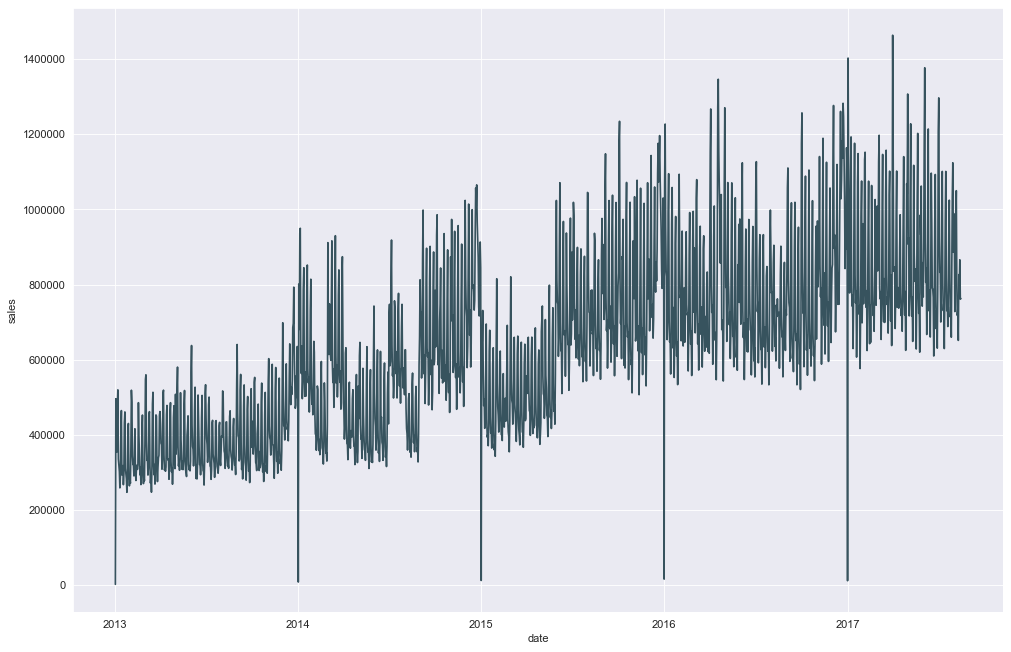

In [15]:
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=80)

plt.ticklabel_format(style='plain', axis='y')

df1=df0.copy()
df1=df1.groupby(by='date').agg('sum').reset_index()
sns.lineplot(x=df1.date,y=df1.sales)

## CONSTRUIR TARGET COM O MÉTODO RECURSIVO

In [34]:
full_recursive = []

for source_key, source_key_df in df1.groupby("store_nbr"):
    source_key_df = source_key_df.copy()
    #source_key_df['yield'] = source_key_df['sales'].diff() # t - t-1
    
#    #mostrar antes da trafo
#    first_data_points_of_day = (source_key_df['DATE_TIME'].dt.hour == 0) & (source_key_df['DATE_TIME'].dt.minute <= 15)
#    source_key_df.loc[first_data_points_of_day, '15M_YIELD'] = 0.
    
#    record_number = source_key_df.groupby(source_key_df['DATE_TIME'].dt.date)['DATE_TIME'].rank()
    #print(record_number)
#    source_key_df.loc[record_number <= 1, '15M_YIELD'] = 0
    #source_key_df['15M_YIELD'].plot()
    
    source_key_df['Y'] = source_key_df['sales'].shift(-15)
    source_key_df = source_key_df.iloc[:-1]
    
    full_recursive.append(source_key_df)
    
full_recursive_df = pd.concat(full_recursive, axis=0, ignore_index=True)

In [36]:
full_recursive_df.head(20)

,date,store_nbr,sales,onpromotion,cluster,dcoilwtico,payment,Y
0,2013-01-01,49005,2511.618999,0,15114,0.00,0,318347.913946
1,2013-01-02,49005,496092.417944,0,15114,165975.48,0,267498.515975
2,2013-01-03,49005,361461.231124,0,15114,165672.54,0,296130.850028
3,2013-01-04,49005,354459.677093,0,15114,165939.84,0,432459.852021
4,2013-01-05,49005,477350.121229,0,15114,0.00,0,461092.386047
5,2013-01-06,49005,519695.401088,0,15114,0.00,0,311211.265950
6,2013-01-07,49005,336122.801066,0,15114,166082.40,0,296214.728983
7,2013-01-08,49005,318347.777981,0,15114,166100.22,0,283258.453032
8,2013-01-09,49005,302530.809018,0,15114,165868.56,0,247245.690995
9,2013-01-10,49005,258982.003049,0,15114,167169.42,0,290022.771930


In [40]:
df2=full_recursive_df.copy()
df2['dcoilwtico']=df2['dcoilwtico'].replace(0,np.nan)
df2.head()

,date,store_nbr,sales,onpromotion,cluster,dcoilwtico,payment,Y
0,2013-01-01,49005,2511.618999,0,15114,NaN,0,318347.913946
1,2013-01-02,49005,496092.417944,0,15114,165975.48,0,267498.515975
2,2013-01-03,49005,361461.231124,0,15114,165672.54,0,296130.850028
3,2013-01-04,49005,354459.677093,0,15114,165939.84,0,432459.852021
4,2013-01-05,49005,477350.121229,0,15114,NaN,0,461092.386047


CRIA FEATURE PAGAMENTO QUINZENAL

In [16]:
df1['payment']=np.where(
    (
    df1['date'].dt.day.isin([15])
|   (df1['date'].dt.is_month_end)
), 1,0)

In [17]:
df1.head()

,date,store_nbr,sales,onpromotion,cluster,dcoilwtico,payment
0,2013-01-01,49005,2511.618999,0,15114,0.00,0
1,2013-01-02,49005,496092.417944,0,15114,165975.48,0
2,2013-01-03,49005,361461.231124,0,15114,165672.54,0
3,2013-01-04,49005,354459.677093,0,15114,165939.84,0
4,2013-01-05,49005,477350.121229,0,15114,0.00,0


In [19]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64